In [14]:
from glob import glob
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from facenet_pytorch import MTCNN
import data

import matplotlib.pyplot as plt

In [8]:
img_size = 160

## Detector

In [83]:
mtcnn = MTCNN(image_size=img_size, margin=40, post_process=False)

## Model

In [84]:
model = torchvision.models.shufflenet_v2_x1_0()
model.fc = nn.Linear(1024, 2)
model.load_state_dict(torch.load('weights/shufflenet_v2_x1_0_fp16.pth'))

model.eval();

## Data

In [85]:
norm_transform = transforms.Normalize(*data.IMAGENET_STATS)

val_transform = transforms.Compose([
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        norm_transform,
    ])

In [135]:
paths = glob('/data/img_align_celeba/*')[:1000]

## Sanity check for model with and without face detection

In [121]:
%%timeit
img_crop = mtcnn(img)

31.1 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [137]:
for p in paths:
    img = Image.open(p)
    img_crop = mtcnn(img)
    if img_crop is None:
        print('Face not found')
        continue
        
    img_crop = norm_transform(img_crop / 255.)
    
    pr = model(val_transform(img).unsqueeze(0))[0]
    pr = torch.argmax(pr).item()
    
    pr_crop = model(img_crop.unsqueeze(0))[0]
    pr_crop = torch.argmax(pr_crop).item()
    
    if pr != pr_crop:
        print('!')

Face not found
!
Face not found
!
!


2 undetected faces per 1000 images, 3 classification changes after face detection per 1000 images

## Visualization center crop and face detection result

In [129]:
def imshow(inp, title=None, figsize=(5, 5)):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(data.IMAGENET_STATS[0])
    std = np.array([data.IMAGENET_STATS[1]])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

### Source

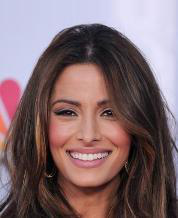

In [139]:
img

### Center crop

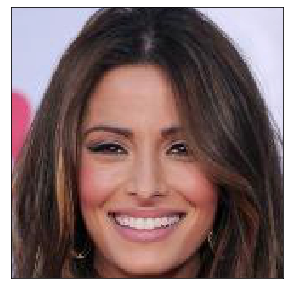

In [140]:
imshow(val_transform(img))

### Face detection

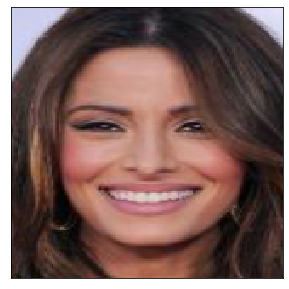

In [141]:
imshow(img_crop)

### Comparison of logits

In [142]:
model(val_transform(img).unsqueeze(0))

tensor([[ 2.2127, -2.1110]], grad_fn=<AddmmBackward>)

In [143]:
model(img_crop.unsqueeze(0))

tensor([[ 2.2381, -2.1375]], grad_fn=<AddmmBackward>)

## Model forward pass speed

In [115]:
val_img = val_transform(img).unsqueeze(0)

In [117]:
%%timeit
model(val_img)

12.6 ms ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
